In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

Q1 :  Get the time series for the following cryptocurrencies from `cryptowat.ch` starting from 2021-11-22, hourly data  
    1. ETH  
    2. SOL  
    3. AVAX  
    4. USDT  
    5. FLOW  

FLOW requires a special attention.

In [2]:
def get_data(token):
    if token == 'FLOW':
        res = requests.get(
        f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    else :
        res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH', 'SOL','AVAX','USDT','FLOW']

In [4]:
df_base = pd.concat(get_data(token) for token in tokens)
dfs = [
    (get_data(token)) 
    for token in tokens
]

In [5]:
df=df_base.set_index('ts')
dfs

[                     ts     open     high      low    close       volume  \
 0   2021-11-22 00:00:00  4317.98  4342.24  4246.07  4262.99  7262.562789   
 1   2021-11-22 01:00:00  4263.04  4270.34  4212.45  4234.37  8437.946084   
 2   2021-11-22 02:00:00  4234.87  4246.72  4171.17  4217.89  9259.725370   
 3   2021-11-22 03:00:00  4217.88  4223.48  4163.58  4193.47  9259.899519   
 4   2021-11-22 04:00:00  4192.95  4213.59  4147.00  4168.35  7934.546906   
 ..                  ...      ...      ...      ...      ...          ...   
 669 2021-12-19 21:00:00  3915.97  3930.33  3897.94  3918.96  2370.742773   
 670 2021-12-19 22:00:00  3918.96  3940.75  3912.82  3922.39  4117.796792   
 671 2021-12-19 23:00:00  3922.38  3995.18  3914.92  3982.18  8017.602275   
 672 2021-12-20 00:00:00  3981.84  3995.01  3913.52  3925.79  5280.171541   
 673 2021-12-20 01:00:00  3925.78  3930.11  3894.01  3908.97  4993.129026   
 
         volumeUSD token  
 0    3.123077e+07   ETH  
 1    3.574586e+07  

Q2 : Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [6]:
df_USDVol=df.groupby('token')['volumeUSD'].agg(np.sum).to_frame().sort_values('volumeUSD',ascending = False)

In [7]:
df_USDVol

,volumeUSD
token,
ETH,2.513414e+10
SOL,8.224712e+09
AVAX,4.470550e+09
USDT,2.276333e+09
FLOW,9.702706e+07


Q3 : Add a column that calculates the close price ratio between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period)

First we join both DataFrames

In [8]:
df_close_ratio= pd.merge(
    dfs[0][['ts','close']],
    dfs[1][['ts','close']],
    on='ts',
    how='inner',
    suffixes=[f'_{tokens[0]}', f'_{tokens[1]}']
)

In [9]:
df_close_ratio.set_index('ts',inplace=True)

Then, we add the required column

In [10]:
df_close_ratio['ratio_close_ETH_SOL']=df_close_ratio['close_ETH']/df_close_ratio['close_SOL']

In [11]:
df_close_ratio

,close_ETH,close_SOL,ratio_close_ETH_SOL
ts,,,
2021-11-22 00:00:00,4262.99,230.785,18.471694
2021-11-22 01:00:00,4234.37,226.000,18.736150
2021-11-22 02:00:00,4217.89,227.037,18.577985
2021-11-22 03:00:00,4193.47,223.117,18.794937
2021-11-22 04:00:00,4168.35,220.652,18.891059
...,...,...,...
2021-12-19 21:00:00,3918.96,180.030,21.768372
2021-12-19 22:00:00,3922.39,179.860,21.808017
2021-12-19 23:00:00,3982.18,183.210,21.735604


Q4 : - Change the name of the `volume` and `volumeUSD` columns to `volumeBase` and `volumeTerm`

In [12]:
df.rename(columns={'volume':'volumeBase','volumeUSD':'volumeTerm'},inplace = True)

In [13]:
df

,open,high,low,close,volumeBase,volumeTerm,token
ts,,,,,,,
2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH
2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH
2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH
2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH
2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH
...,...,...,...,...,...,...,...
2021-12-19 21:00:00,8.369,8.385,8.359,8.385,362.858445,3.039935e+03,FLOW
2021-12-19 22:00:00,8.401,8.405,8.361,8.362,2351.228288,1.968667e+04,FLOW
2021-12-19 23:00:00,8.352,8.409,8.352,8.409,1433.708991,1.200528e+04,FLOW


Q5 : Create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of  200 rows and 5 columns)

In [14]:
dfs_close=(dfs[0][['ts', 'close']].rename(columns={'close': f'close_{tokens[0]}'}),
dfs[1][['ts', 'close']].rename(columns={'close': f'close_{tokens[1]}'}),
dfs[2][['ts', 'close']].rename(columns={'close': f'close_{tokens[2]}'}),
dfs[3][['ts', 'close']].rename(columns={'close': f'close_{tokens[3]}'}),
dfs[4][['ts', 'close']].rename(columns={'close': f'close_{tokens[4]}'}))
dfs_close

(                     ts  close_ETH
 0   2021-11-22 00:00:00    4262.99
 1   2021-11-22 01:00:00    4234.37
 2   2021-11-22 02:00:00    4217.89
 3   2021-11-22 03:00:00    4193.47
 4   2021-11-22 04:00:00    4168.35
 ..                  ...        ...
 669 2021-12-19 21:00:00    3918.96
 670 2021-12-19 22:00:00    3922.39
 671 2021-12-19 23:00:00    3982.18
 672 2021-12-20 00:00:00    3925.79
 673 2021-12-20 01:00:00    3908.97
 
 [674 rows x 2 columns],
                      ts  close_SOL
 0   2021-11-22 00:00:00    230.785
 1   2021-11-22 01:00:00    226.000
 2   2021-11-22 02:00:00    227.037
 3   2021-11-22 03:00:00    223.117
 4   2021-11-22 04:00:00    220.652
 ..                  ...        ...
 669 2021-12-19 21:00:00    180.030
 670 2021-12-19 22:00:00    179.860
 671 2021-12-19 23:00:00    183.210
 672 2021-12-20 00:00:00    179.950
 673 2021-12-20 01:00:00    178.140
 
 [674 rows x 2 columns],
                      ts  close_AVAX
 0   2021-11-22 00:00:00      128.67
 1   202

We will use the reduce function from functools that allow us to join lultiple DataFrames.

In [15]:
from functools import reduce

In [16]:
df_close = reduce(lambda  left,right: pd.merge(left,right,on='ts',
                                            how='inner'), dfs_close)

In [17]:
df_close.set_index('ts',inplace=True)

In [18]:
df_close

,close_ETH,close_SOL,close_AVAX,close_USDT,close_FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581
...,...,...,...,...,...
2021-12-19 21:00:00,3918.96,180.030,108.39,1.0004,8.385
2021-12-19 22:00:00,3922.39,179.860,108.90,1.0004,8.362
2021-12-19 23:00:00,3982.18,183.210,109.81,1.0005,8.409


Q6 Calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1}))

We do a simple loop to get those log returns

In [19]:
for i in tokens :
    df_close[f'Hourly_Log_Returns_{i}']=np.log(df_close[f'close_{i}']/df_close[f'close_{i}'].shift(1))
df_close

,close_ETH,close_SOL,close_AVAX,close_USDT,close_FLOW,Hourly_Log_Returns_ETH,Hourly_Log_Returns_SOL,Hourly_Log_Returns_AVAX,Hourly_Log_Returns_USDT,Hourly_Log_Returns_FLOW
ts,,,,,,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581,-0.006008,-0.011109,0.021583,-0.0002,-0.005214
...,...,...,...,...,...,...,...,...,...,...
2021-12-19 21:00:00,3918.96,180.030,108.39,1.0004,8.385,0.000763,-0.002275,-0.001199,-0.0001,0.000358
2021-12-19 22:00:00,3922.39,179.860,108.90,1.0004,8.362,0.000875,-0.000945,0.004694,0.0000,-0.002747
2021-12-19 23:00:00,3982.18,183.210,109.81,1.0005,8.409,0.015128,0.018454,0.008322,0.0001,0.005605


\[Stretch\] calculate the correlation of the tokens using the table above

We drop the Close columns to get only log returns.

In [20]:
df_log_returns=df_close.drop(['close_ETH','close_SOL','close_AVAX','close_USDT','close_FLOW'],axis=1)

In [21]:
df_log_returns

,Hourly_Log_Returns_ETH,Hourly_Log_Returns_SOL,Hourly_Log_Returns_AVAX,Hourly_Log_Returns_USDT,Hourly_Log_Returns_FLOW
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214
...,...,...,...,...,...
2021-12-19 21:00:00,0.000763,-0.002275,-0.001199,-0.0001,0.000358
2021-12-19 22:00:00,0.000875,-0.000945,0.004694,0.0000,-0.002747
2021-12-19 23:00:00,0.015128,0.018454,0.008322,0.0001,0.005605


Finnaly we use : .correl() to get the correlations.

In [22]:
correl=df_log_returns.corr()
correl

,Hourly_Log_Returns_ETH,Hourly_Log_Returns_SOL,Hourly_Log_Returns_AVAX,Hourly_Log_Returns_USDT,Hourly_Log_Returns_FLOW
Hourly_Log_Returns_ETH,1.000000,0.759011,0.654867,-0.088822,0.583407
Hourly_Log_Returns_SOL,0.759011,1.000000,0.647366,0.106267,0.477690
Hourly_Log_Returns_AVAX,0.654867,0.647366,1.000000,0.012522,0.405584
Hourly_Log_Returns_USDT,-0.088822,0.106267,0.012522,1.000000,-0.175806
Hourly_Log_Returns_FLOW,0.583407,0.477690,0.405584,-0.175806,1.000000


\[Stretch\] visualize the correlation in a matplpotlib plot

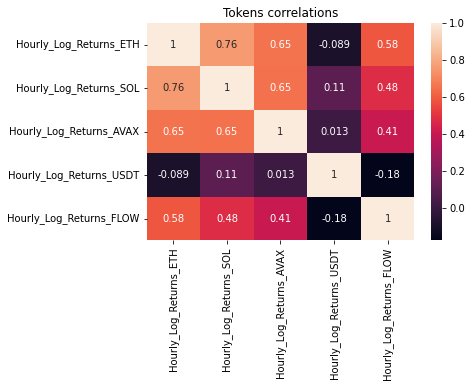

In [23]:
import seaborn as sns
sns.heatmap(correl, annot=True)
plt.title('Tokens correlations')
plt.show()